# Generating PSF for a filter
## Things to complete
- Align the objects in the centre
- Generate PSF using multiple sources

In [1]:
# import modules
from astropy.io import fits
from photutils.detection import find_peaks
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from photutils.psf import extract_stars, EPSFBuilder
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from photutils.segmentation import detect_threshold

Filename: DESJ233551.8640-515217.7600_z.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      84   (228, 228)   float32   
  1  MSK           1 ImageHDU        76   (228, 228)   int32   
  2  WGT           1 ImageHDU        66   (228, 228)   float32   


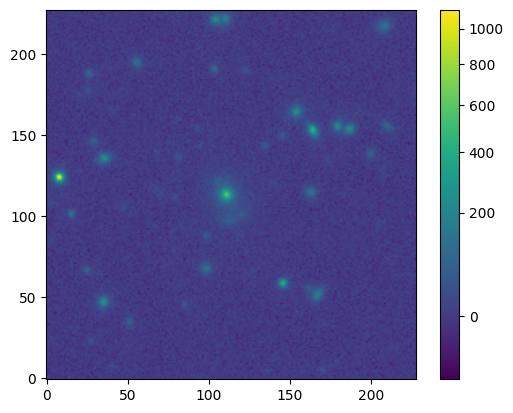

In [2]:
# import image data
data = fits.open("DESJ233551.8640-515217.7600_z.fits")
image_data = data[0].data #image_data in the first header
data.info()

# plot image data
norm = simple_norm(image_data, 'sqrt') # generating the normalisation for plotting
plt.figure()
plt.imshow(image_data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

In [3]:
# finding peaks to extract point sources
# threshold = detect_threshold(image_data, nsigma=15.0) #threshold for detection
peaks_tbl = find_peaks(image_data, threshold=500) # generate table of detected sources
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output  
print(peaks_tbl)  

x_peak y_peak peak_value
------ ------ ----------
   111    113  592.17285
     8    124  1114.6609


In [4]:
size = 25
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (image_data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (image_data.shape[0] -1 - hsize)))  

In [5]:
galaxy_tbl = Table()
galaxy_tbl['x'] = x[mask]  
galaxy_tbl['y'] = y[mask]

In [6]:
mean, median, std = sigma_clipped_stats(image_data, sigma=2.0) # generate the mean and std
image_data -= median
nddata = NDData(data=image_data)  

IndexError: list index out of range

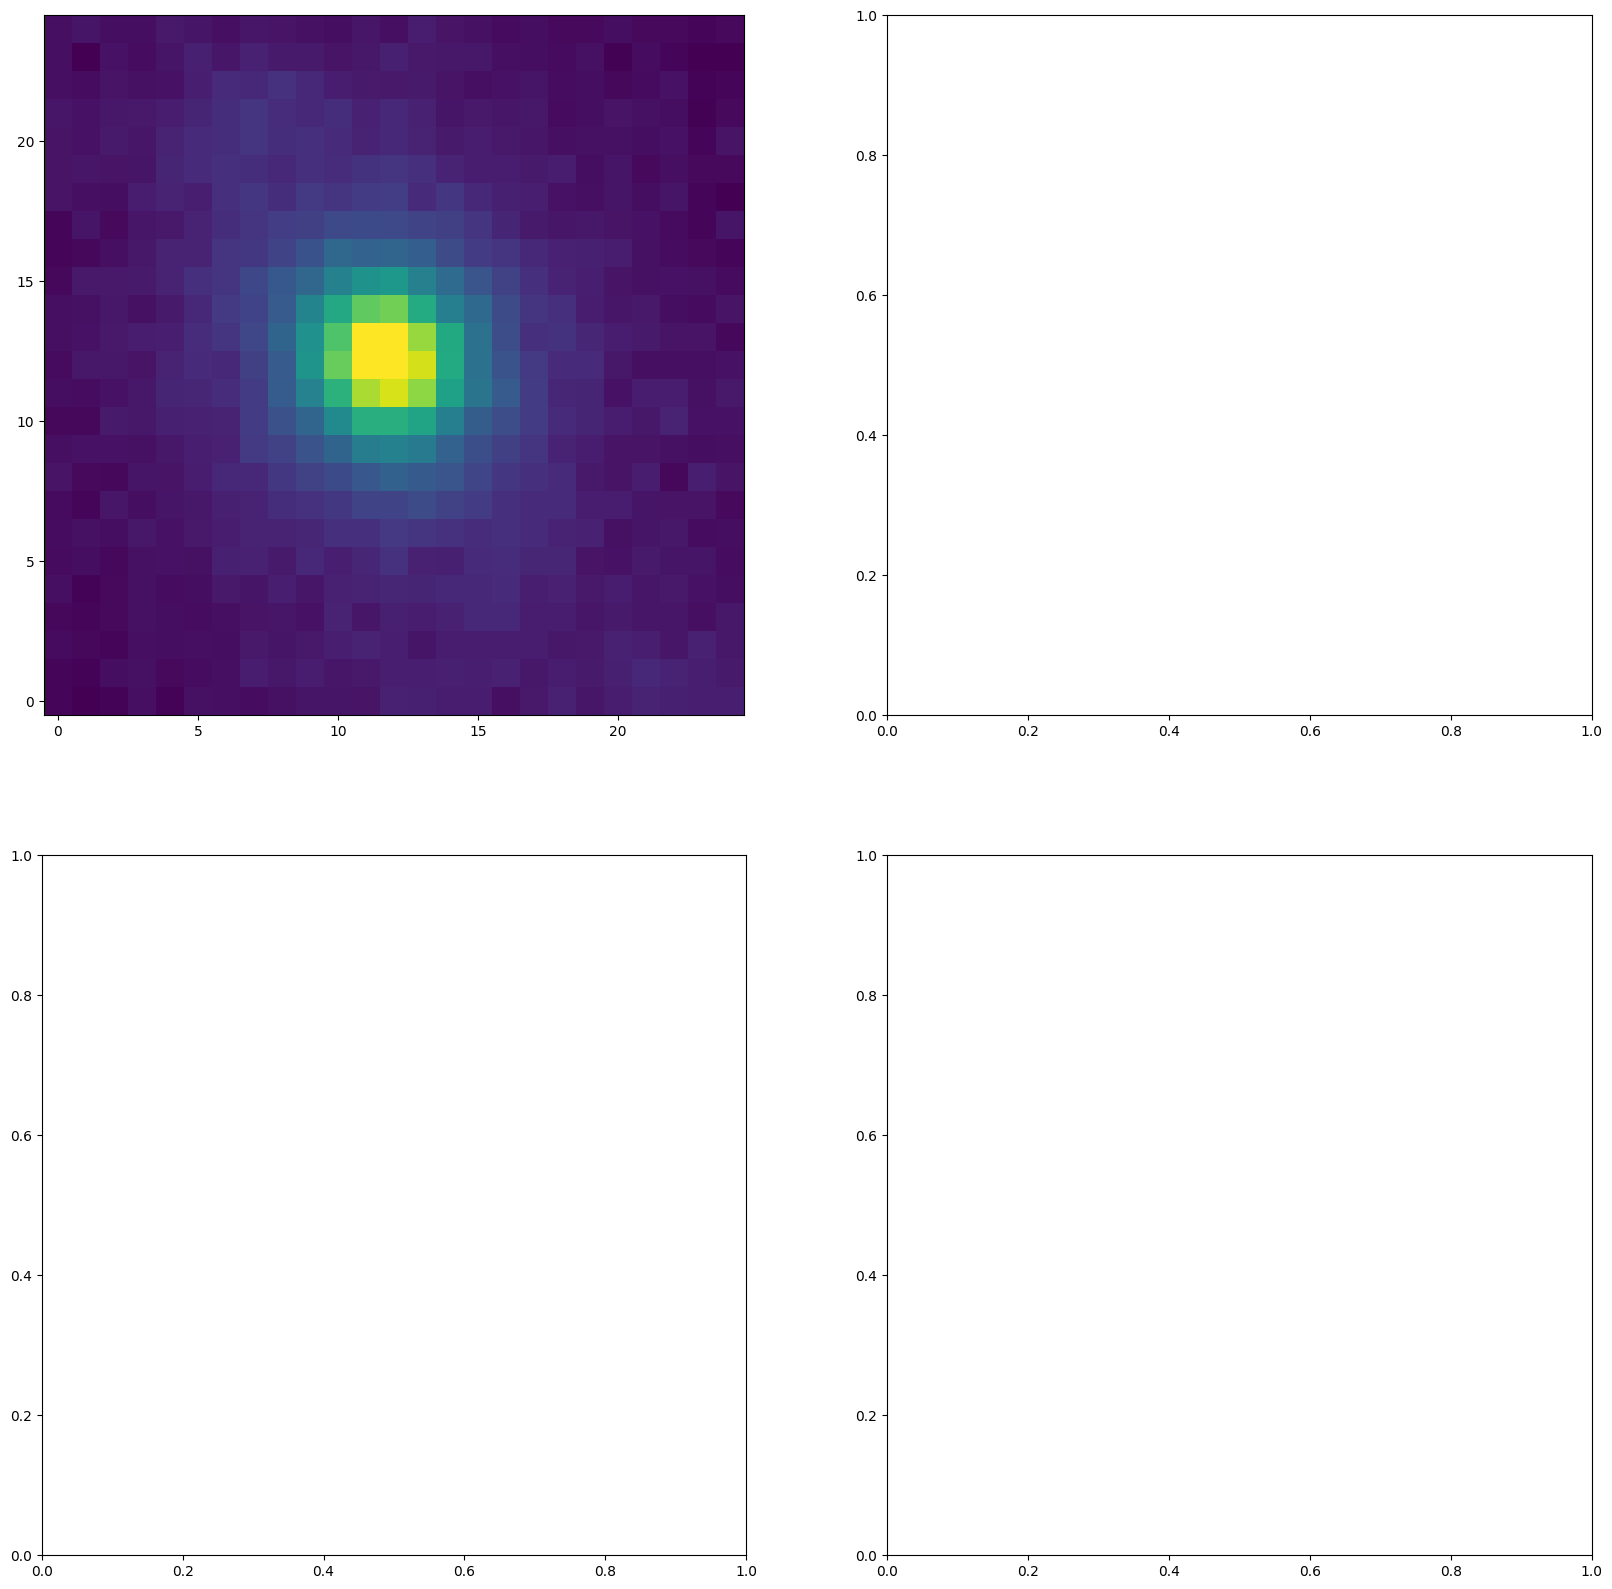

In [7]:
galaxy = extract_stars(nddata, galaxy_tbl, size=25)
nrows = 2
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(galaxy[i], percent=99.0)
    ax[i].imshow(galaxy[i], norm=norm, origin='lower', cmap='viridis')

In [8]:
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3,
                           progress_bar=False)  
epsf, fitted_galaxy = epsf_builder(galaxy)  

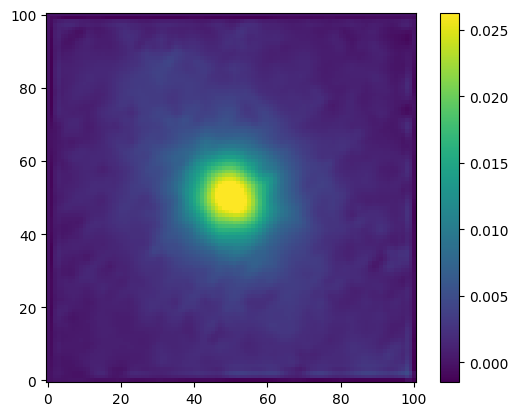

In [9]:
norm = simple_norm(epsf.data, percent=99.0)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

In [10]:
hdu = fits.PrimaryHDU(epsf.data)
hdu.writeto('z_epsf.fits', overwrite=True)